In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical, SeveralSourceDataset
from data import data_dirs as data_env, get_label_with_context

from model import (
    UnetR34, get_resnet34,
    accuracy_segmentation, tensorboard_cb, jaccard_index_one_class, jaccard_index_zero_class
)

from result_visualization import show_results

from fastai.vision import (
    Learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType,
    plt,   # matplotlib.pyplot
    nn,    # torch.nn
    optim  # torch.optim
)
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [36]:
sizes = 256

src = (
    SegItemListCustom
    .from_folder(data_env.get_subdir("root"))
    .split_by_folder("train_skyFinder", "test_iphoneXR_v")
    .label_from_func(get_label_with_context,
                     classes=["Sky", "Other"])
)
train_data = (
    src
    .transform(tfms=get_transforms()
                  , size=sizes, tfm_y=True)
    .databunch(bs=17)
    .normalize(imagenet_stats)
)
classes = train_data.c
train_data.valid_dl.batch_size = 7

# train_data.show_batch(figsize=(15,10), title="Train")
# train_data.show_batch(figsize=(15,10), title="Val", ds_type=DatasetType.Valid)

In [40]:
train_data.train_ds

LabelList (7587 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /home/dmitri/Documents/Datasets/skyFinderMod

In [29]:
model = UnetR34(get_resnet34(), classes_num=classes)

learner = Learner(train_data, model)
learner.opt_fn = optim.Adam
learner.loss_fn = nn.BCEWithLogitsLoss()
learner.metrics = [accuracy_segmentation, jaccard_index_one_class, jaccard_index_zero_class]

# learner.freeze_to(1)

In [31]:
print("Model: Unet34")

print("Trainable: {}".format(t_sum))

sum = 0
t_sum = 0
for name, p in learner.model.named_parameters():
    t = 0
    if p.requires_grad:
        t = p.numel()
    print("Layer: {0}, parameters: {1}, trainable: {2}".format(name, p.numel(), t))
    sum += p.numel()
    t_sum += t

Model: Unet34
Trainable: 26730306
Layer: backbone.0.weight, parameters: 9408, trainable: 9408
Layer: backbone.1.weight, parameters: 64, trainable: 64
Layer: backbone.1.bias, parameters: 64, trainable: 64
Layer: backbone.4.0.conv1.weight, parameters: 36864, trainable: 36864
Layer: backbone.4.0.bn1.weight, parameters: 64, trainable: 64
Layer: backbone.4.0.bn1.bias, parameters: 64, trainable: 64
Layer: backbone.4.0.conv2.weight, parameters: 36864, trainable: 36864
Layer: backbone.4.0.bn2.weight, parameters: 64, trainable: 64
Layer: backbone.4.0.bn2.bias, parameters: 64, trainable: 64
Layer: backbone.4.1.conv1.weight, parameters: 36864, trainable: 36864
Layer: backbone.4.1.bn1.weight, parameters: 64, trainable: 64
Layer: backbone.4.1.bn1.bias, parameters: 64, trainable: 64
Layer: backbone.4.1.conv2.weight, parameters: 36864, trainable: 36864
Layer: backbone.4.1.bn2.weight, parameters: 64, trainable: 64
Layer: backbone.4.1.bn2.bias, parameters: 64, trainable: 64
Layer: backbone.4.2.conv1.we

epoch,train_loss,valid_loss,accuracy_segmentation,jaccard_index_one_class,jaccard_index_zero_class,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 1.74E-02


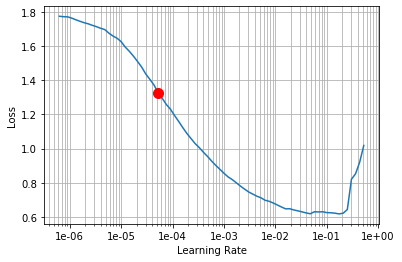

In [4]:
learner.lr_find()
learner.recorder.plot(suggestion=True, show_grid=True)

In [33]:
tb_callback = tensorboard_cb("/home/dmitri/Documents/tensorboard_logs", log_name="unet34_osp_full_s256_mlr1e3_bs17_e25")

In [34]:
learner.fit_one_cycle(25, max_lr=1e-03, callbacks=[tb_callback(learner)])
# learner.fit(epochs=25, lr=1e-03, callbacks=[tb_callback(learner)])
learner.recorder.plot_lr(show_moms=True)

epoch,train_loss,valid_loss,accuracy_segmentation,jaccard_index_one_class,jaccard_index_zero_class,time


RuntimeError: CUDA out of memory. Tried to allocate 272.00 MiB (GPU 0; 5.93 GiB total capacity; 1.66 GiB already allocated; 187.94 MiB free; 2.09 GiB reserved in total by PyTorch)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



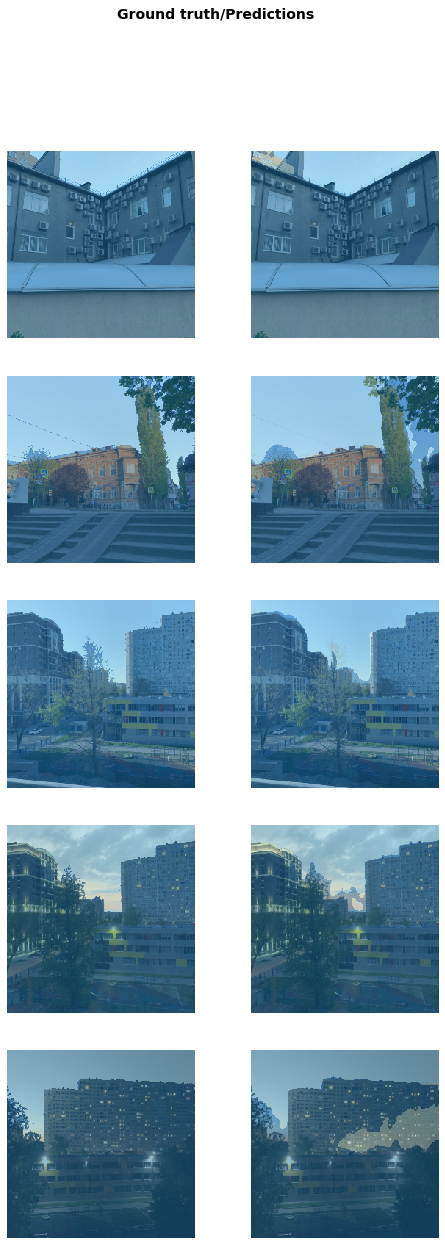

In [7]:
learner.show_results()

In [8]:
learner.save("/home/dmitri/Documents/model_weights/unet34/unet34_osp_full_e18_mlr1e3_bs17_2d")
learner.export("/home/dmitri/Documents/model_weights/unet34/unet34_osp_full_e18_mlr1e3_bs17_2d")

In [9]:
model.close()